In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import scipy.optimize as optimize
import numpy as np
import statsmodels.api as sm
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from scipy.interpolate import griddata

from IPython.display import display, HTML
display(HTML("<style>.jp-Cell { margin-left: -35% !important; margin-right: -35% !important; }</style>"))

In [2]:
def extract_tasklog_features(tasklog_path: str):
    """
    주어진 .tasklog 파일을 읽어서 Required Accelerator Count를 그룹화한 후,
    Accumulated Age의 평균 및 최대값을 특성 벡터로 반환.

    :param tasklog_path: .tasklog 파일 경로
    :return: 특성 벡터를 포함한 딕셔너리
    """
    # .tasklog 파일 읽기
    try:
        tasklog_data = pd.read_csv(tasklog_path)
    except Exception as e:
        print(f"Error reading {tasklog_path}: {e}")
        return {}

    # Required Accelerator Count 그룹의 평균 및 최대 Accumulated Age 계산
    grouped_data_mean = tasklog_data.groupby('Required Accelerator Count')['Accumulated Age'].mean()
    grouped_data_max = tasklog_data.groupby('Required Accelerator Count')['Accumulated Age'].max()

    # 특성 벡터 생성
    feature_vector = {}
    
    # 평균값과 최대값을 벡터에 추가
    for count, age_mean in grouped_data_mean.items():
        feature_vector[f'Avg_Age_Accel_{count}'] = age_mean
    
    for count, age_max in grouped_data_max.items():
        feature_vector[f'Max_Age_Accel_{count}'] = age_max

    return feature_vector

In [3]:
def extract_reference_rows(df: pd.DataFrame):
    """
    주어진 DataFrame에서 'preemption enabling'이 FALSE이고 'starvation prevention'이 FALSE인 행을 추출하여
    별도의 CSV 파일로 저장.

    :param df: 기준 데이터를 추출할 pandas DataFrame
    :param output_path: 추출된 데이터를 저장할 CSV 파일 경로 (기본값: 'reference_rows.csv')
    :return: 추출된 기준 행들을 포함한 pandas DataFrame
    """
    # 기준 열을 추출 (preemption enabling이 FALSE이고 starvation prevention이 FALSE인 행)
    reference_df = df[(df['preemption enabling'] == False) & (df['starvation prevention'] == False)]
   
    return reference_df

In [4]:
def add_time_gain_column_with_ref(df: pd.DataFrame, ref: pd.Series):
    """
    기준(ref)의 Total Emulation minutes을 사용하여, 각 row의 Total Emulation minutes과 Ajust task taken time(min)의 차이를 
    time gain이라는 컬럼으로 추가.

    :param df: pandas DataFrame
    :param ref: 기준이 되는 row (pandas Series)
    :return: time gain 컬럼이 추가된 DataFrame
    """
    # ref의 Total Emulation minutes 값을 가져옴
    #ref_total_emulation_minutes = ref['Total Emulation minutes']
    #ref_total_emulation_minutes = ref['Total Emulation minutes'].values[0] if isinstance(ref['Total Emulation minutes'], pd.Series) else ref['Total Emulation minutes']
    ref_total_emulation_minutes = float(ref['Total Emulation minutes'].values[0]) if isinstance(ref['Total Emulation minutes'], pd.Series) else float(ref['Total Emulation minutes'])

    # 결측값 처리
    if pd.isna(ref_total_emulation_minutes):
        raise ValueError("기준 Total Emulation minutes 값이 유효하지 않습니다.")
   
    # 기준(ref)의 Total Emulation minutes에서 각 row의 Total Emulation minutes과 Ajust task taken time(min)의 합을 빼서 새로운 컬럼 추가
    df['Peemption gain'] = df.apply(lambda row: ref_total_emulation_minutes - row['Total Emulation minutes'] - row['Ajust task taken time(min)'] 
                               if row['preemption enabling'] == True else 0, axis=1)
    
    
    return df

In [5]:
def calculate_dist_for_all_rows(df: pd.DataFrame, ref: pd.Series):
    """
    df의 모든 row와 ref의 값을 비교하여 Accumulated avg dist와 Accumulated max dist를 계산.
    람다식을 사용하여 계산하고, 각 row에 결과를 추가함.
    """

    # 가중치 설정
    weights = [1 / (2 ** (8 - i)) for i in range(1, 9)]  # [1, 1/2, 1/4, ..., 1/128]

    # Accumulated avg dist 계산
    df['Accumulated avg dist'] = df.apply(lambda row: sum(
        (row[f'Avg_Age_Accel_{i}'] - ref[f'Avg_Age_Accel_{i}']) * weights[i - 1]
        if f'Avg_Age_Accel_{i}' in df.columns and f'Avg_Age_Accel_{i}' in ref else 0 for i in range(1, 9)), axis=1)

    # Accumulated max dist 계산
    df['Accumulated max dist'] = df.apply(lambda row: sum(
        (row[f'Max_Age_Accel_{i}'] - ref[f'Max_Age_Accel_{i}']) * weights[i - 1]
        if f'Max_Age_Accel_{i}' in df.columns and f'Max_Age_Accel_{i}' in ref else 0 for i in range(1, 9)), axis=1)

    return df


In [6]:
def merge_meta_files_to_csv(folder_path: str, overwrite: bool = False, output_csv: str = 'merged_meta_data.csv'):
    """
    주어진 폴더에서 .meta 파일을 읽어 첫 줄을 무시하고, 각 파일의 key-value 데이터를 하나의 CSV 파일로 병합하고,
    동일한 이름의 .tasklog 파일에서 Required Accelerator Count 특성 벡터를 추출하여 추가.

    :param folder_path: .meta 파일들이 위치한 폴더 경로
    :param output_csv: 결과로 저장할 CSV 파일 이름 (기본값: 'merged_meta_data.csv')
    :return: 병합된 데이터가 포함된 pandas DataFrame
    """

    output_csv_path = os.path.join(folder_path, output_csv)

    # 기존에 merged_meta_data.csv 파일이 있는 경우, 해당 파일을 읽어서 반환
    if os.path.exists(output_csv_path):
        if not overwrite:
            print(f"Found existing file: {output_csv_path}. Reading the file.")
            return pd.read_csv(output_csv_path)
        else:
            print(f"Found existing file: {output_csv_path}. Overwriting as requested.")

        
    # .meta 파일을 읽어서 각 파일의 데이터를 저장할 리스트
    data_list = []

    # 폴더 내 모든 .meta 파일을 찾음
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.meta'):
            # 파일 경로 설정
            file_path = os.path.join(folder_path, file_name)
            
            # 각 .meta 파일을 읽어서 데이터를 key-value 형식으로 저장
            data = {}
            with open(file_path, 'r', encoding='utf-8') as file:
                # 첫 줄을 건너뛰고 두 번째 줄부터 읽음
                next(file)  # 첫 줄 무시
                for line in file:
                    if ',' in line:
                        key, value = line.strip().split(',', 1)
                        data[key] = value
            
            # .meta 파일과 동일한 이름의 .tasklog 파일 경로 설정
            tasklog_file_path = file_path.replace('.meta', '.tasklog')
            if os.path.exists(tasklog_file_path):
               # print(f"Found corresponding tasklog file: {tasklog_file_path}")
                # tasklog 파일에서 특성 벡터를 추출
                tasklog_features = extract_tasklog_features(tasklog_file_path)
                if tasklog_features:
                   
                    # 특성 벡터를 .meta 데이터에 병합
                    data.update(tasklog_features)
                
            # data_list에 추가
            data_list.append(data)

    # 모든 파일의 데이터를 DataFrame으로 변환
    df = pd.DataFrame(data_list)

    # 중복된 데이터를 제거 (job file, save prefix 제외)
    cols_to_compare = df.columns.difference(['start time', 'Expriment taken(msec)', 'Expriment taken', 'job file', 'save prefix'])
    df_unique = df.drop_duplicates(subset=cols_to_compare)

    # 입력된 폴더 경로에 CSV 파일 저장
    df_unique.to_csv(output_csv_path, index=False)
    df = pd.read_csv(output_csv_path)

    print(f"Data merged and saved to {output_csv_path}")

    ref = extract_reference_rows(df)
    df_with_gain = add_time_gain_column_with_ref(df, ref)
    df_with_gain_n_accumulate_dis = calculate_dist_for_all_rows(df_with_gain, ref)
    df_with_gain_n_accumulate_dis.to_csv(output_csv_path, index=False)

    
    return pd.read_csv(output_csv_path)

In [7]:
log_dir = "calculated"
log_target = "all_lognorm_gen"
pictures_dir = os.path.join(log_dir, "analysis_pictures")

# pictures 디렉토리가 없으면 생성
if not os.path.exists(pictures_dir):
    os.makedirs(pictures_dir)

# log_target 이름의 하위 폴더 생성
target_dir = os.path.join(pictures_dir, log_target)
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

In [8]:
df = merge_meta_files_to_csv(os.path.join(log_dir, log_target))
df

Found existing file: calculated/all_lognorm_gen/merged_meta_data.csv. Reading the file.


,start time,scheduler index,scheduler name,Total Job,Total Duration(Expected),Total Emulation minutes,Total Emulation Time,Expriment taken(msec),Expriment taken,preemption enabling,...,Max_Age_Accel_2,Max_Age_Accel_3,Max_Age_Accel_4,Max_Age_Accel_5,Max_Age_Accel_6,Max_Age_Accel_7,Max_Age_Accel_8,Peemption gain,Accumulated avg dist,Accumulated max dist
0,2024-11-15 09:13:25+00:00,0,mostallocated,1000,35381,38337,26 Day(s) 14:57,501,00:00:00:501,True,...,1527,1063,2351,2119,1138,1282,1869,4354.0,-280.202554,-1666.945312
1,2024-11-15 09:13:24+00:00,0,mostallocated,1000,35381,39178,27 Day(s) 04:58,1022,00:00:01:022,True,...,1488,1247,1795,1608,1933,1559,2697,3398.0,-169.304426,-594.640625
2,2024-11-15 09:13:25+00:00,0,mostallocated,1000,35381,39327,27 Day(s) 07:27,624,00:00:00:624,True,...,1503,1621,1602,2974,2782,963,1924,3364.0,-243.885050,-1283.015625
3,2024-11-15 09:13:24+00:00,0,mostallocated,1000,35381,39521,27 Day(s) 10:41,697,00:00:00:697,True,...,1529,1840,1520,3215,2764,1642,2186,3170.0,-171.712234,-654.171875
4,2024-11-15 09:13:25+00:00,0,mostallocated,1000,35381,40701,28 Day(s) 06:21,540,00:00:00:540,True,...,1686,1575,1538,3198,3409,2027,2475,1990.0,-92.794970,-17.929688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35306,2024-11-15 11:45:59+00:00,0,mostallocated,1000,35381,39601,27 Day(s) 12:01,330,00:00:00:330,True,...,1325,1275,1429,3452,1814,917,2141,2995.0,-251.164891,-1298.156250
35307,2024-11-15 11:46:00+00:00,0,mostallocated,1000,35381,38337,26 Day(s) 14:57,293,00:00:00:293,True,...,1527,1063,2351,2119,1138,1282,1869,4354.0,-280.202554,-1666.945312
35308,2024-11-15 11:46:00+00:00,0,mostallocated,1000,35381,38872,26 Day(s) 23:52,338,00:00:00:338,True,...,1411,1209,2870,2503,1738,743,2891,3799.0,-299.082630,-682.164062
35309,2024-11-15 11:45:59+00:00,0,mostallocated,1000,35381,38928,27 Day(s) 00:48,321,00:00:00:321,True,...,1263,1179,1819,2699,2203,154,1402,3733.0,-366.289414,-2395.125000


/tmp/ipykernel_57172/1357091091.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_range['alpha'] = pd.to_numeric(df_range['alpha'], errors='coerce')
/tmp/ipykernel_57172/1357091091.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_range['beta'] = pd.to_numeric(df_range['beta'], errors='coerce')
/tmp/ipykernel_57172/1357091091.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

alpha: 0.0 ~ 1.99
beta: 80 ~ 95
w: 20 ~ 200
d: 100000 ~ 500000


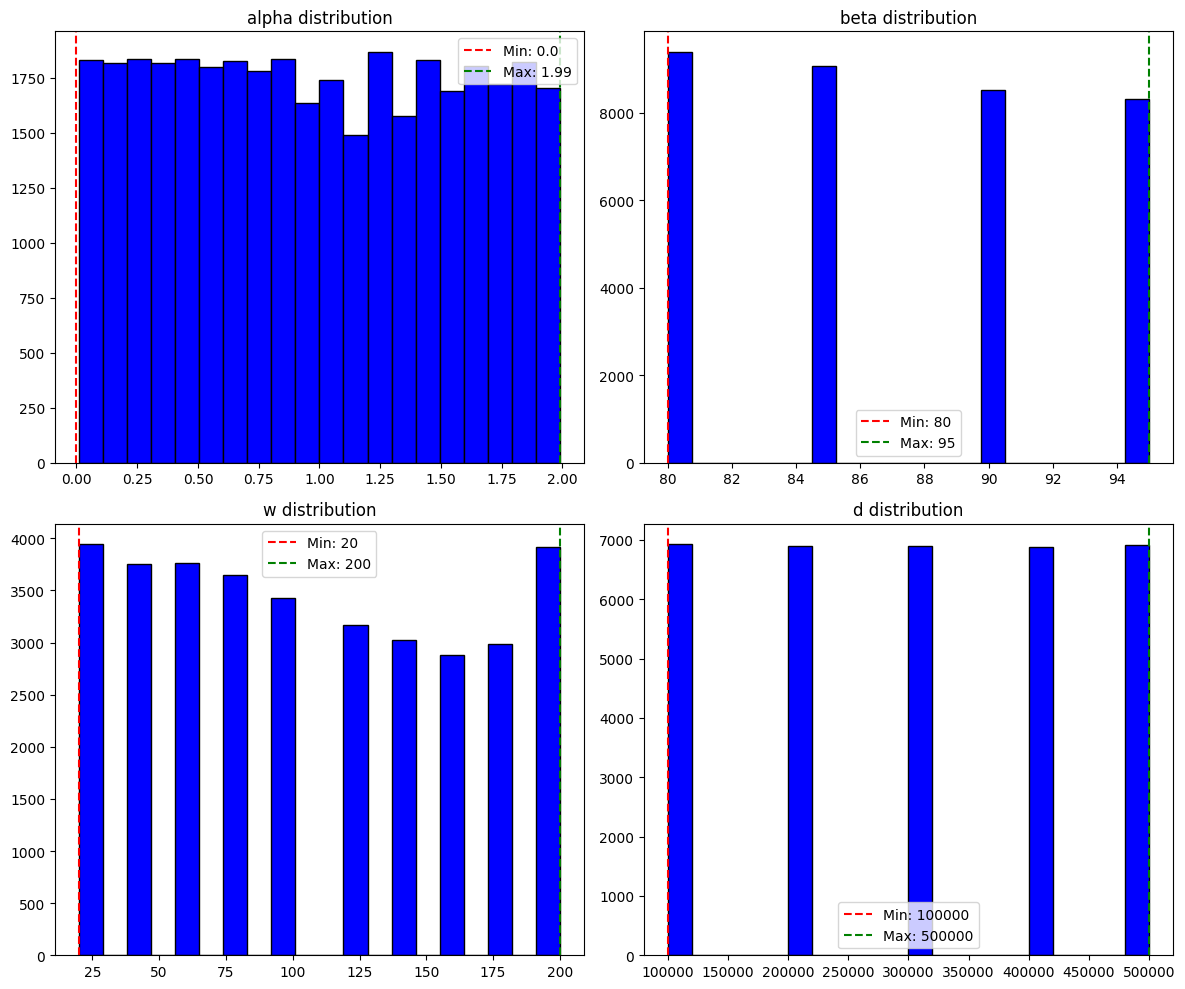

In [9]:
# alpha, beta, w, d 컬럼 선택
df_range = df[['alpha', 'beta', 'w', 'd']]

# 각 컬럼을 숫자형으로 변환 (변환 불가능한 값은 NaN으로 처리)
df_range['alpha'] = pd.to_numeric(df_range['alpha'], errors='coerce')
df_range['beta'] = pd.to_numeric(df_range['beta'], errors='coerce')
df_range['w'] = pd.to_numeric(df_range['w'], errors='coerce')
df_range['d'] = pd.to_numeric(df_range['d'], errors='coerce')

# NaN 값 제거
df_range = df_range.dropna()

# 0을 제외한 각 컬럼의 최소값, 최대값 계산
alpha_min, alpha_max = df_range['alpha'].min(), df_range[df_range['alpha'] > 0]['alpha'].max()
beta_min, beta_max = df_range[df_range['beta'] > 0]['beta'].min(), df_range[df_range['beta'] > 0]['beta'].max()
w_min, w_max = df_range[df_range['w'] > 0]['w'].min(), df_range[df_range['w'] > 0]['w'].max()
d_min, d_max = df_range[df_range['d'] > 0]['d'].min(), df_range[df_range['d'] > 0]['d'].max()

# 결과 출력
print(f"alpha: {alpha_min} ~ {alpha_max}")
print(f"beta: {beta_min} ~ {beta_max}")
print(f"w: {w_min} ~ {w_max}")
print(f"d: {d_min} ~ {d_max}")

plt.figure(figsize=(12, 10))

# alpha
plt.subplot(2, 2, 1)
plt.hist(df_range[df_range['alpha'] > 0]['alpha'], bins=20, color='blue', edgecolor='black')
plt.axvline(alpha_min, color='red', linestyle='--', label=f'Min: {alpha_min}')
plt.axvline(alpha_max, color='green', linestyle='--', label=f'Max: {alpha_max}')
plt.title('alpha distribution')
plt.legend()

# beta
plt.subplot(2, 2, 2)
plt.hist(df_range[df_range['beta'] > 0]['beta'], bins=20, color='blue', edgecolor='black')
plt.axvline(beta_min, color='red', linestyle='--', label=f'Min: {beta_min}')
plt.axvline(beta_max, color='green', linestyle='--', label=f'Max: {beta_max}')
plt.title('beta distribution')
plt.legend()

# w
plt.subplot(2, 2, 3)
plt.hist(df_range[df_range['w'] > 0]['w'], bins=20, color='blue', edgecolor='black')
plt.axvline(w_min, color='red', linestyle='--', label=f'Min: {w_min}')
plt.axvline(w_max, color='green', linestyle='--', label=f'Max: {w_max}')
plt.title('w distribution')
plt.legend()

# d
plt.subplot(2, 2, 4)
plt.hist(df_range[df_range['d'] > 0]['d'], bins=20, color='blue', edgecolor='black')
plt.axvline(d_min, color='red', linestyle='--', label=f'Min: {d_min}')
plt.axvline(d_max, color='green', linestyle='--', label=f'Max: {d_max}')
plt.title('d distribution')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(target_dir, log_target + "_hyperparameter_dist.png"))
plt.show()

In [10]:
# Total Emulation minutes, alpha, beta, w, d 컬럼 선택 및 전처리
df_selected = df[['Total Emulation minutes', 'alpha', 'beta', 'w', 'd']].dropna()

df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 종속 변수와 독립 변수 정의
X = df_selected[['alpha', 'beta', 'w', 'd']]  # 독립 변수
y = df_selected['Total Emulation minutes']    # 종속 변수

# 상수항 추가 (절편을 포함하기 위해)
X = sm.add_constant(X)

# 회귀 분석 모델 생성 및 학습
model = sm.OLS(y, X).fit()

# 분석 결과 출력
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     Total Emulation minutes   R-squared:                       0.665
Model:                                 OLS   Adj. R-squared:                  0.665
Method:                      Least Squares   F-statistic:                 1.755e+04
Date:                     Fri, 15 Nov 2024   Prob (F-statistic):               0.00
Time:                             13:03:31   Log-Likelihood:            -2.7598e+05
No. Observations:                    35311   AIC:                         5.520e+05
Df Residuals:                        35306   BIC:                         5.520e+05
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

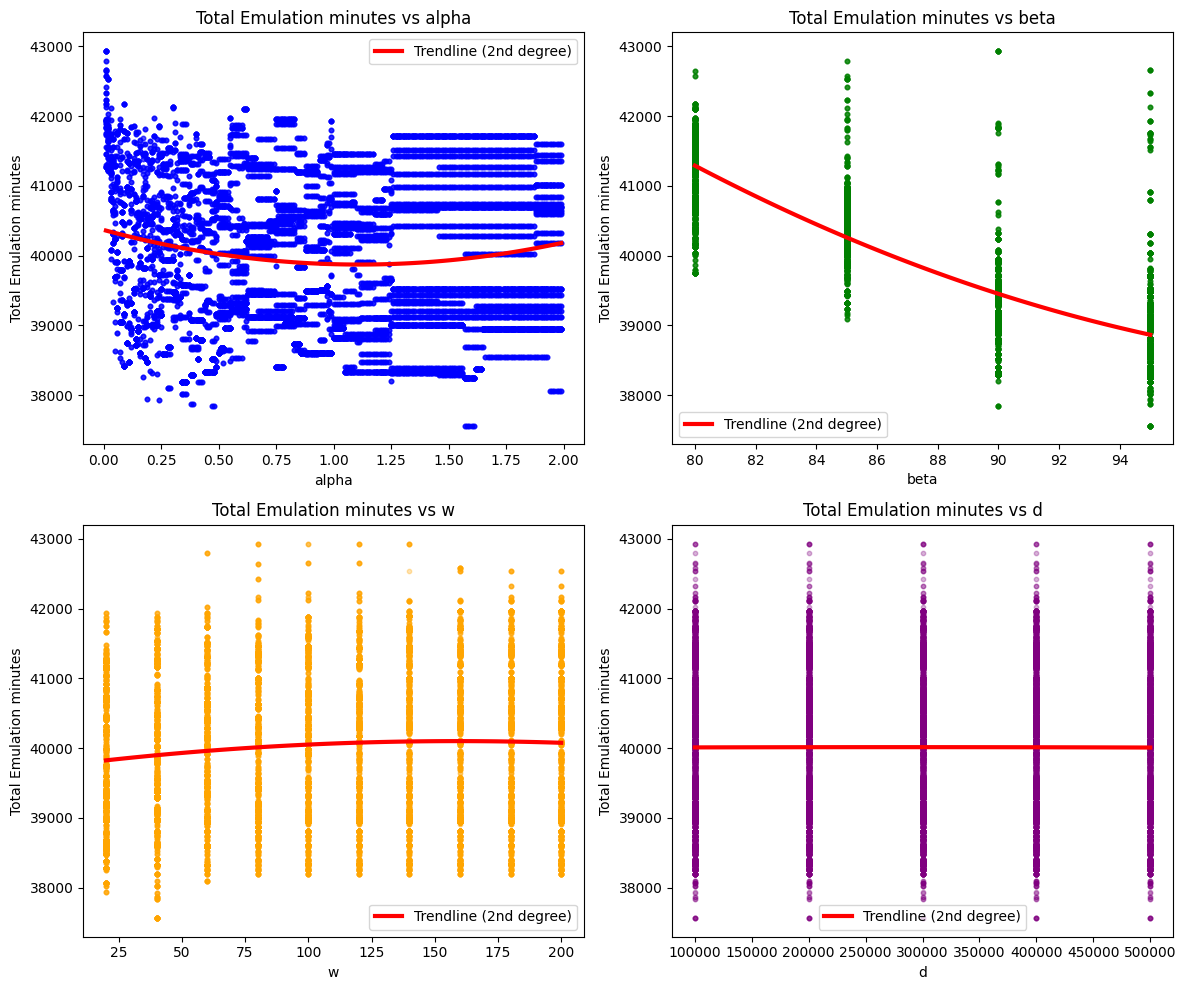

In [11]:
variables_to_plot = ['alpha', 'beta', 'w', 'd']
filtered_data = df[(df['alpha'] != 0) & (df['beta'] != 0) & (df['w'] != 0) & (df['d'] != 0)]

# 색상 설정
colors = ['blue', 'green', 'orange', 'purple']

# 산점도와 2차 회귀 추세선 그리기
plt.figure(figsize=(12, 10))

for i, (var, color) in enumerate(zip(variables_to_plot, colors), 1):
    plt.subplot(2, 2, i)
    
    # 산점도 그리기 (각 변수에 맞는 색상)
    plt.scatter(filtered_data[var], filtered_data['Total Emulation minutes'], alpha=0.3, color=color, s=10)
    
    # 2차 회귀 추세선 그리기 (붉은색으로)
    poly_fit = np.poly1d(np.polyfit(filtered_data[var], filtered_data['Total Emulation minutes'], 2))
    poly_line = np.linspace(filtered_data[var].min(), filtered_data[var].max(), 100)
    
    plt.plot(poly_line, poly_fit(poly_line), color='red', linewidth=3, label='Trendline (2nd degree)')
    
    plt.title(f'Total Emulation minutes vs {var}')
    plt.xlabel(var)
    plt.ylabel('Total Emulation minutes')
    plt.legend()

# 그래프 출력
plt.tight_layout()
plt.savefig(os.path.join(target_dir, log_target + "_trend_greaph.png"), dpi=300, bbox_inches='tight')
plt.show()

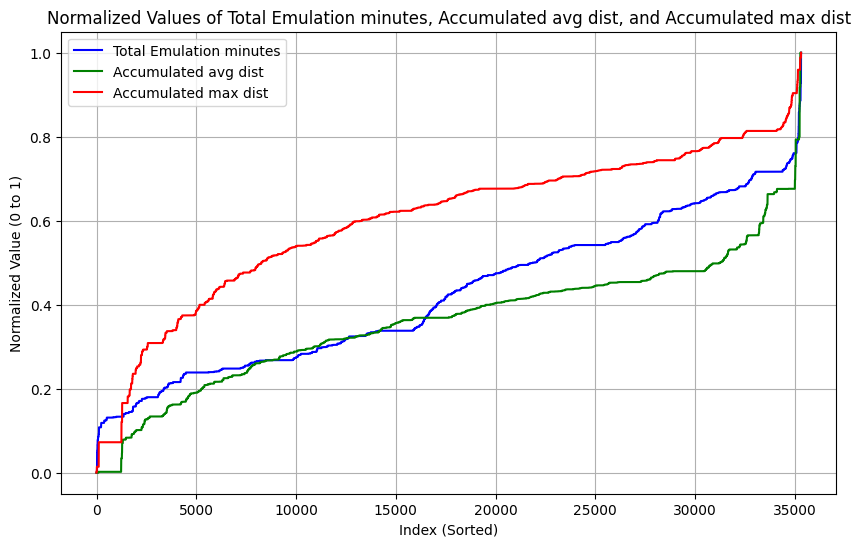

In [12]:
# Extract the three columns to be normalized and sorted
columns_to_normalize = ['Total Emulation minutes', 'Accumulated avg dist', 'Accumulated max dist']
data_to_normalize = df[columns_to_normalize]

# Sort each column in ascending order
data_sorted = data_to_normalize.apply(sorted, axis=0)

# Normalize the sorted data using MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data_sorted)

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(data_normalized[:, 0], label='Total Emulation minutes', color='blue')
plt.plot(data_normalized[:, 1], label='Accumulated avg dist', color='green')
plt.plot(data_normalized[:, 2], label='Accumulated max dist', color='red')

plt.title('Normalized Values of Total Emulation minutes, Accumulated avg dist, and Accumulated max dist')
plt.xlabel('Index (Sorted)')
plt.ylabel('Normalized Value (0 to 1)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(target_dir, log_target + "_total_emul_trade_off.png"), dpi=300, bbox_inches='tight')
plt.show()

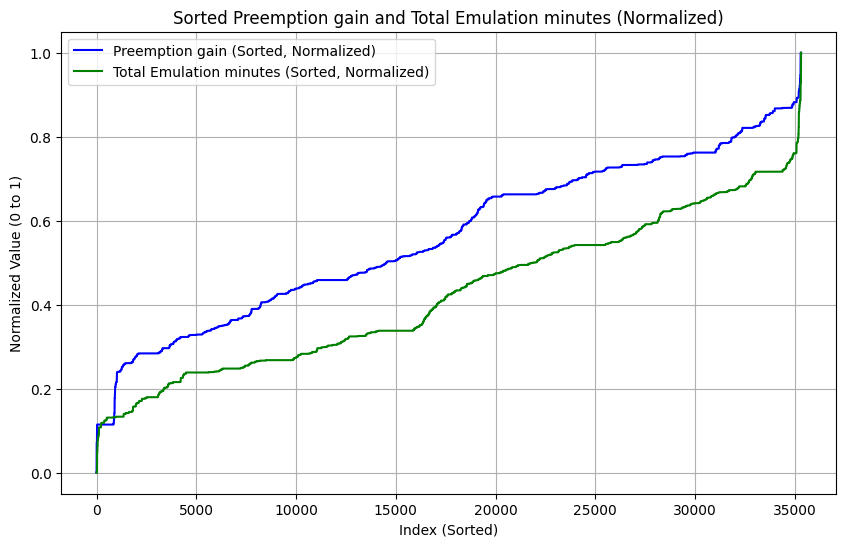

In [13]:
columns_to_plot = ['Peemption gain', 'Total Emulation minutes']
data_to_plot = df[columns_to_plot]
# Sort the Peemption gain and Total Emulation minutes columns in ascending order
data_sorted_plot = data_to_plot.apply(sorted, axis=0)

# Normalize the sorted data
data_normalized_sorted = scaler.fit_transform(data_sorted_plot)

# Plot the normalized, sorted Peemption gain and Total Emulation minutes
plt.figure(figsize=(10, 6))
plt.plot(data_normalized_sorted[:, 0], label='Preemption gain (Sorted, Normalized)', color='blue')
plt.plot(data_normalized_sorted[:, 1], label='Total Emulation minutes (Sorted, Normalized)', color='green')

# Customize the plot
plt.title('Sorted Preemption gain and Total Emulation minutes (Normalized)')
plt.xlabel('Index (Sorted)')
plt.ylabel('Normalized Value (0 to 1)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(target_dir, log_target + "_preemption_trade_off.png"), dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Normalization and optimization of alpha and beta
numeric_columns = [
    'alpha', 'beta', 'w', 'd',
    'Total Emulation minutes', 'Peemption gain',
    'Accumulated avg dist', 'Accumulated max dist'
]

for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df_alpha_beta = df[(df['alpha'] != 0) & (df['beta'] != 0)]
grouped_alpha_beta = df_alpha_beta.groupby(['alpha', 'beta']).agg({
    'Total Emulation minutes': 'mean',
    'Accumulated avg dist': 'mean',
    'Accumulated max dist': 'mean'
}).reset_index()

scaler = MinMaxScaler()
grouped_alpha_beta[['Total Emulation minutes_norm', 'Accumulated avg dist_norm', 'Accumulated max dist_norm']] = scaler.fit_transform(
    grouped_alpha_beta[['Total Emulation minutes', 'Accumulated avg dist', 'Accumulated max dist']]
)

grouped_alpha_beta['Objective'] = grouped_alpha_beta['Total Emulation minutes_norm'] + grouped_alpha_beta['Accumulated avg dist_norm'] + grouped_alpha_beta['Accumulated max dist_norm']
optimal_alpha_beta = grouped_alpha_beta.loc[grouped_alpha_beta['Objective'].idxmin()]

# Optimization for w and d
df_w_d = df[(df['w'] != 0) & (df['d'] != 0)]
grouped_w_d = df_w_d.groupby(['w', 'd']).agg({
    'Total Emulation minutes': 'mean',
    'Peemption gain': 'mean',
    'Expriment taken(msec)': 'mean'
}).reset_index()

grouped_w_d[['Total Emulation minutes_norm', 'Peemption gain_norm', 'Expriment taken(msec)_norm']] = scaler.fit_transform(
    grouped_w_d[['Total Emulation minutes', 'Peemption gain', 'Expriment taken(msec)']]
)

grouped_w_d['Objective'] = grouped_w_d['Total Emulation minutes_norm'] + grouped_w_d['Expriment taken(msec)_norm'] - grouped_w_d['Peemption gain_norm']
optimal_w_d = grouped_w_d.loc[grouped_w_d['Objective'].idxmin()]

print("최적의 alpha와 beta 값:")
optimal_alpha_beta = optimal_alpha_beta.round(2).astype(str)
print(optimal_alpha_beta[['alpha', 'beta', 'Total Emulation minutes', 'Accumulated avg dist', 'Accumulated max dist']])

print("\n최적의 w와 d 값:")
optimal_w_d = optimal_w_d.round(2).astype(str)
print(optimal_w_d[['w', 'd', 'Total Emulation minutes', 'Peemption gain', 'Expriment taken(msec)']])

최적의 alpha와 beta 값:
alpha                          1.63
beta                           95.0
Total Emulation minutes    38516.86
Accumulated avg dist        -372.77
Accumulated max dist       -3284.17
Name: 651, dtype: object

최적의 w와 d 값:
w                              20.0
d                          100000.0
Total Emulation minutes    39838.33
Peemption gain              2759.17
Expriment taken(msec)       2547.91
Name: 0, dtype: object


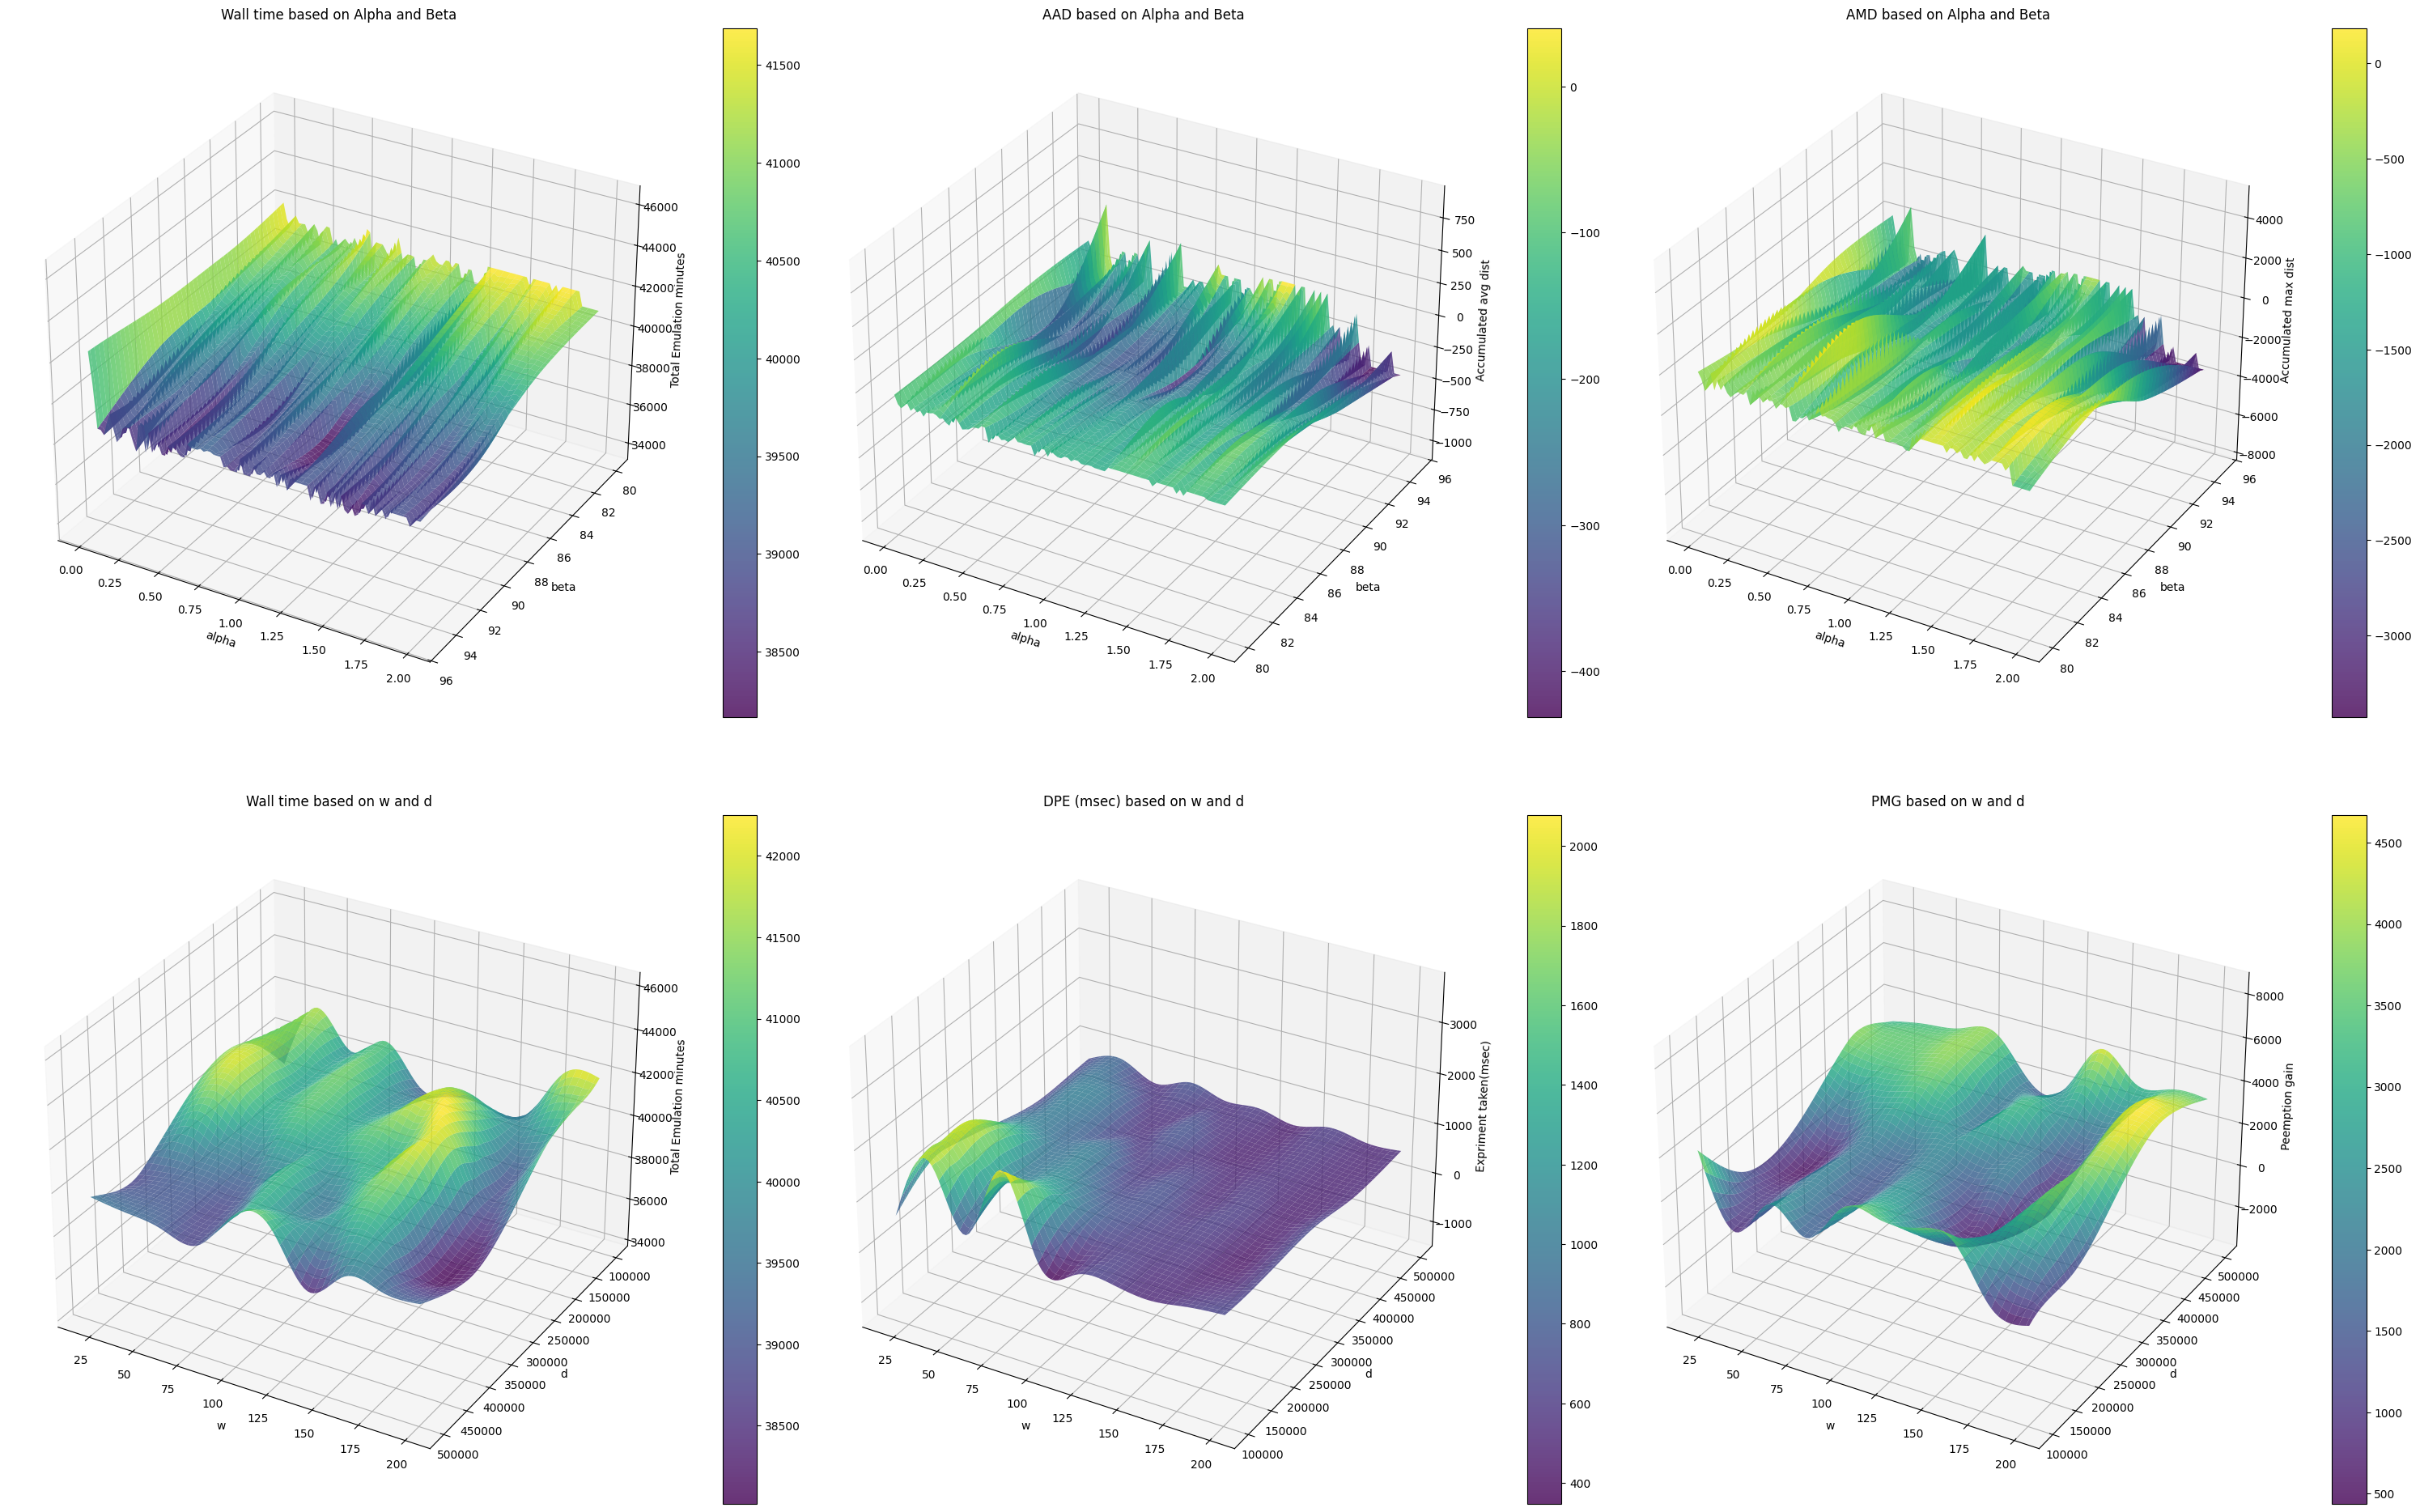

In [15]:
def plot_3d_mesh(df, x_var, y_var, metric, title, y_inverse=False, ax=None):
    """
    지정된 x_var와 y_var에 따른 metric의 3D 메쉬 그래프를 그립니다.

    매개변수:
    - df: pandas DataFrame, 데이터가 포함된 데이터프레임
    - x_var: string, x축에 사용할 열의 이름
    - y_var: string, y축에 사용할 열의 이름
    - metric: string, z축(메트릭)에 사용할 열의 이름
    - title: string, 그래프의 제목
    - y_inverse: bool, y축을 반전할지 여부 (기본값: False)
    - ax: matplotlib Axes 객체, 그래프를 그릴 축 (기본값: None)
    """

    # 필요한 열을 숫자형으로 변환
    numeric_columns = [x_var, y_var, metric]
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # x_var, y_var, metric 값이 유효한 행만 선택
    df_filtered = df[(df[x_var] != 0) & (df[y_var] != 0)].dropna(subset=numeric_columns)

    # x_var, y_var, metric 값 추출
    x = df_filtered[x_var].values
    y = df_filtered[y_var].values
    metric_values = df_filtered[metric].values

    # 그리드를 생성하기 위한 x와 y의 범위 설정
    x_lin = np.linspace(df_filtered[x_var].min(), df_filtered[x_var].max(), 100)
    y_lin = np.linspace(df_filtered[y_var].min(), df_filtered[y_var].max(), 100)
    x_grid, y_grid = np.meshgrid(x_lin, y_lin)

    # griddata를 사용하여 Cubic 보간 수행
    metric_grid = griddata(
        points=(x, y),
        values=metric_values,
        xi=(x_grid, y_grid),
        method='cubic'
    )

    # NaN 값을 최근접 이웃으로 채우기
    metric_grid = np.where(
        np.isnan(metric_grid),
        griddata(
            points=(x, y),
            values=metric_values,
            xi=(x_grid, y_grid),
            method='nearest'
        ),
        metric_grid
    )

    # metric 값의 최소 및 최대 값 계산
    metric_min = np.nanmin(metric_grid)
    metric_max = np.nanmax(metric_grid)
    data_range = metric_max - metric_min

    # Z축 범위 설정 (데이터 범위의 3배로 설정하여 중간 1/3에 데이터가 위치하도록 함)
    z_min = metric_min - data_range
    z_max = metric_max + data_range

    # Axes 객체가 제공되지 않으면 새로운 Figure와 Axes 생성
    if ax is None:
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

    # 3D 서피스 그래프 그리기
    surf = ax.plot_surface(
        x_grid,
        y_grid,
        metric_grid,
        cmap='viridis',
        edgecolor='none',
        alpha=0.8
    )

    # 축 레이블과 제목 설정
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)
    ax.set_zlabel(metric)
    ax.set_title(title, pad=20)

    # Z축 범위 설정
    ax.set_zlim(z_min, z_max)

    # y축을 반전할지 여부
    if y_inverse:
        ax.invert_yaxis()

    # 컬러바는 메인 코드에서 추가해야 함
    return surf

# 데이터프레임 df가 이미 존재한다고 가정합니다.

fraction_value=0.046
pad_value=0.07

# 3x2 서브플롯 생성
fig = plt.figure(figsize=(30, 20))
axes = []

# 서브플롯 생성 및 그래프 그리기
# 첫 번째 그래프
ax1 = fig.add_subplot(2, 3, 1, projection='3d')
surf1 = plot_3d_mesh(
    df, 'alpha', 'beta',
    metric='Total Emulation minutes',
    title='Wall time based on Alpha and Beta',
    y_inverse=True,
    ax=ax1
)
fig.colorbar(surf1, ax=ax1, fraction=fraction_value, pad=pad_value)


# 두 번째 그래프
ax2 = fig.add_subplot(2, 3, 2, projection='3d')
surf2 = plot_3d_mesh(
    df, 'alpha', 'beta',
    metric='Accumulated avg dist',
    title='AAD based on Alpha and Beta',
    y_inverse=False,
    ax=ax2
)
fig.colorbar(surf2, ax=ax2, fraction=fraction_value, pad=pad_value)

# 세 번째 그래프
ax3 = fig.add_subplot(2, 3, 3, projection='3d')
surf3 = plot_3d_mesh(
    df, 'alpha', 'beta',
    metric='Accumulated max dist',
    title='AMD based on Alpha and Beta',
    y_inverse=False,
    ax=ax3
)
fig.colorbar(surf3, ax=ax3, fraction=fraction_value, pad=pad_value)

# 네 번째 그래프
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
surf4 = plot_3d_mesh(
    df, 'w', 'd',
    metric='Total Emulation minutes',
    title='Wall time based on w and d',
    y_inverse=True,
    ax=ax4
)
fig.colorbar(surf4, ax=ax4, fraction=fraction_value, pad=pad_value)

# 다섯 번째 그래프

ax5 = fig.add_subplot(2, 3, 5, projection='3d')
surf5 = plot_3d_mesh(
    df, 'w', 'd',
    metric='Expriment taken(msec)',
    title='DPE (msec) based on w and d',
    y_inverse=False,
    ax=ax5
)
fig.colorbar(surf5, ax=ax5, fraction=fraction_value, pad=pad_value)

# 여섯 번째 그래프
ax6 = fig.add_subplot(2, 3, 6, projection='3d')
surf6 = plot_3d_mesh(
    df, 'w', 'd',
    metric='Peemption gain',
    title='PMG based on w and d',
    y_inverse=False,
    ax=ax6
)
fig.colorbar(surf6, ax=ax6, fraction=fraction_value, pad=pad_value)

# 서브플롯 간 간격 조정
plt.tight_layout()

# 전체 그래프 표시

plt.savefig(os.path.join(target_dir, log_target + "_hyperparameter_subplots.png"), dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# SHAP 시각화를 위한 자바스크립트 초기화
shap.initjs()


# Total Emulation minutes, alpha, beta, w, d 컬럼 선택
df_selected = df[['Total Emulation minutes', 'alpha', 'beta', 'w', 'd']].dropna()

# 데이터 타입 확인 및 변환 (문자열이 있을 경우 숫자로 변환)
df_selected['Total Emulation minutes'] = pd.to_numeric(df_selected['Total Emulation minutes'], errors='coerce')
df_selected['alpha'] = pd.to_numeric(df_selected['alpha'], errors='coerce')
df_selected['beta'] = pd.to_numeric(df_selected['beta'], errors='coerce')
df_selected['w'] = pd.to_numeric(df_selected['w'], errors='coerce')
df_selected['d'] = pd.to_numeric(df_selected['d'], errors='coerce')

# 변환 후 NaN 값이 있을 경우 제거
df_selected = df_selected.dropna()

# 독립 변수 중에서 alpha, beta, w, d 가 0을 초과하는 값만 선택
df_selected = df_selected[(df_selected['alpha'] > 0) & (df_selected['beta'] > 0) &
                          (df_selected['w'] > 0) & (df_selected['d'] > 0)]

# 독립 변수 (X)와 종속 변수 (y) 정의
X = df_selected[['alpha', 'beta', 'w', 'd']]
y = df_selected['Total Emulation minutes']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 회귀 모델 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

SHAP Waterfall Plot for the first sample:


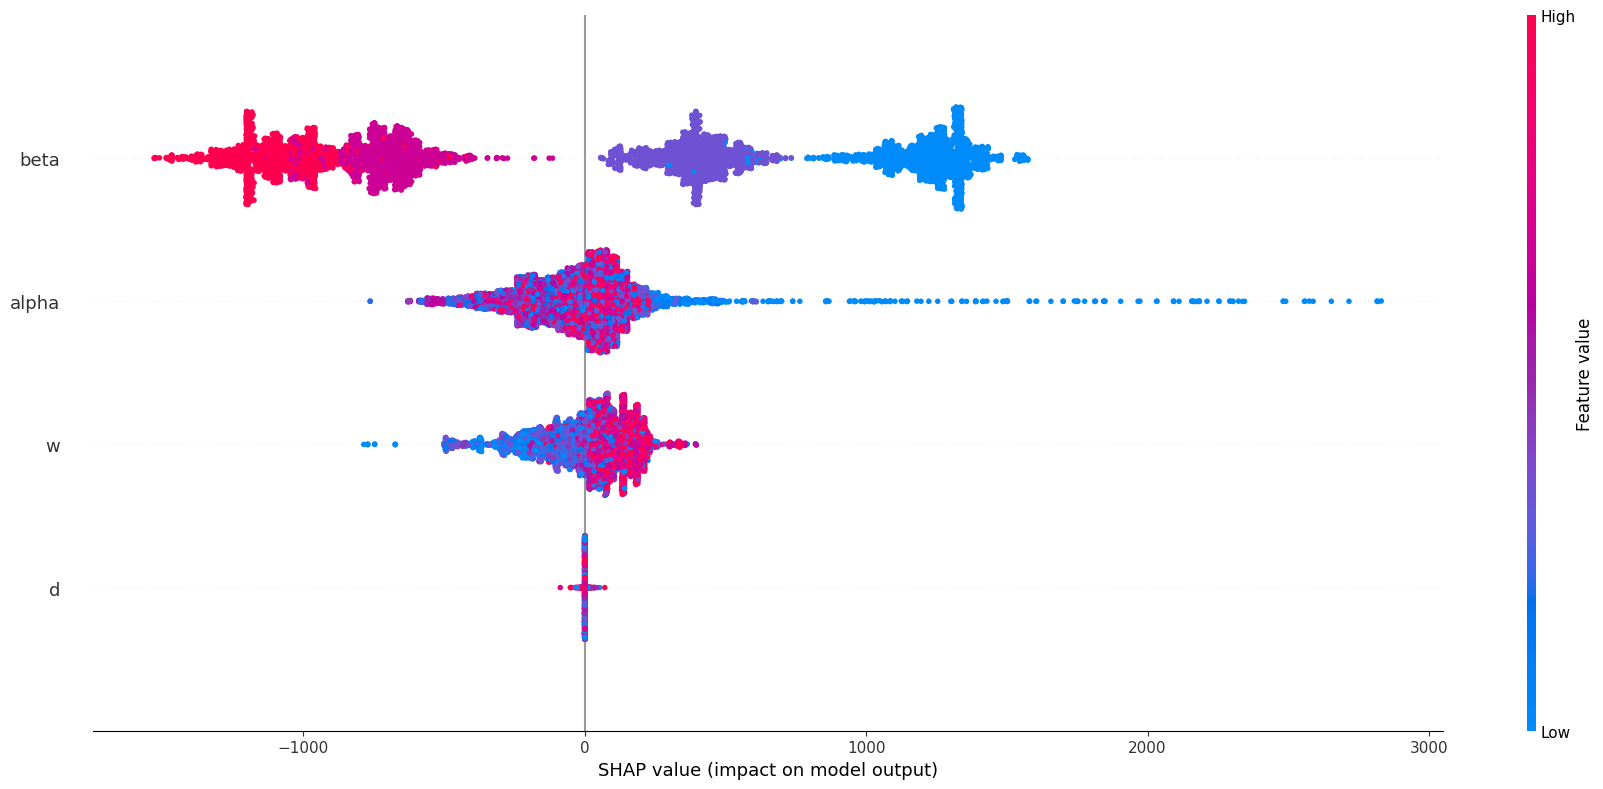

In [17]:
# SHAP 요약 플롯 출력 (bar 형태로 변경)
#shap.summary_plot(shap_values, plot_type='bar')
#shap.summary_plot(shap_values, X_test, feature_names=['alpha', 'beta', 'w', 'd'], plot_size=[18,8])
#plt.show()

# SHAP Waterfall Plot 추가 (첫 번째 샘플에 대해)
print("SHAP Waterfall Plot for the first sample:")
#shap.waterfall_plot(shap_values[0])
shap.summary_plot(shap_values, X_test, feature_names=['alpha', 'beta', 'w', 'd'], plot_size=[18,8], show=False)
plt.savefig(os.path.join(target_dir, log_target + "_hyperparameter_SHAP.png"), dpi=300, bbox_inches='tight')
